In [1]:
__depends__ = [
    "../outputs/online_budget_runs.h5",
    "../outputs/online_budget_runs_permafrost.h5",
    "../outputs/offline_budget_runs_co2_only.h5",
    "../outputs/offline_budget_runs_no_permafrost.h5",
    "../outputs/offline_budget_runs_zec.h5",
    "../outputs/offline_budget_runs_tcre.h5",
    "utils_openscm.py",
    "utils_plotting.py",
    "utils_processing.py",
    "utils_config.py",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UVIC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_BERN.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_LLNL.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CCSM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CLIMBER.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_MPI.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_FRCGC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UMD2.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_HADLEY.CFG",
]
__dest__ = [
    "../figures/online_budget_temperature_cumulative_co2.pdf",
    "../outputs/zec_scatter_df.h5",
    "../outputs/zec_scatter_df_peak_temp.h5",
    "../outputs/zec_scatter_df_zero_emms.h5",
    "../outputs/zec_iam_df.h5",
    "../outputs/permafrost_plt_df.h5",
    "../outputs/nonco2_iam_df.h5",
    "../outputs/nonco2_scatter_df.h5",
    "../outputs/offline_tcre_df.h5",
    "../outputs/online_budget_runs_df.h5",
]

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [3]:
RUN_OUTPUT_ONLINE_BUDGET = __depends__[0]
RUN_OUTPUT_ONLINE_BUDGET_PERMAFROST = __depends__[1]
RUN_OUTPUT_OFFLINE_BUDGET_CO2_ONLY = __depends__[2]
RUN_OUTPUT_OFFLINE_BUDGET_NO_PERMAFROST = __depends__[3]
RUN_OUTPUT_OFFLINE_BUDGET_ZEC = __depends__[4]
RUN_OUTPUT_OFFLINE_BUDGET_TCRE = __depends__[5]
CARBON_CYCLE_FILES = {
    "UVIC": __depends__[10],
    "BERN": __depends__[11],
    "LLNL": __depends__[12],
    "CCSM1": __depends__[13],
    "CLIMBER": __depends__[14],
    "MPI": __depends__[15],
    "FRCGC": __depends__[16],
    "UMD2": __depends__[17],
    "HADLEY": __depends__[18],
}

ONLINE_BUDGET_CUMULATIVE_EMISSIONS_TEMP_FIGURE = __dest__[0]

ZEC_SCATTER_DF_H5 = __dest__[1]
ZEC_SCATTER_DF_PEAK_TEMP_H5 = __dest__[2]
ZEC_SCATTER_DF_ZERO_EMMS_H5 = __dest__[3]
ZEC_IAM_DF_H5 = __dest__[4]

PERMAFROST_PLT_DF_H5 = __dest__[5]

NONCO2_IAM_DF_H5 = __dest__[6]
NONCO2_SCATTER_DF_H5 = __dest__[7]

OFFLINE_TCRE_DF_H5 = __dest__[8]

ONLINE_BUDGET_RUNS_DF_H5 = __dest__[9]

<IPython.core.display.Javascript object>

# Budget Analysis

In this notebook we analyse the results of our online and offline budget runs.

## Imports

In [4]:
import glob
import os
from distutils.util import strtobool

import pandas as pd

from openscm.scmdataframe import df_append, ScmDataFrame

from utils_openscm import load_scmdataframe, save_scmdataframe, save_df
from utils_processing import (
    add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf,
    get_zero_variable_scenarios_year_before_zero_variable_peak_temp_thereafter_rows,
    get_1_percent_tcre_df,
    convert_to_gtco2,
    wrangle_nans,
    CUMULATIVE_EMISSIONS_REF_YEAR,
    CUMULATIVE_EMISSIONS_REF_PERIOD_ID_STRING,
    REF_PERIOD_START,
    REF_PERIOD_END,
    REF_PERIOD_ID_STRING,
)
from utils_config import TEST_RUN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting config

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from utils_plotting import setup

setup()

<IPython.core.display.Javascript object>

## Constants

In [6]:
SHOW_PLOTS = True and not strtobool(
    os.getenv("CI", "False")
)  # turn on if using the notebooks interactively

<IPython.core.display.Javascript object>

## Analysis

To match SR1.5, here we provide all temperature results relative to the 2006-2015 mean.

### Pre-processing raw output

Load data, keeping only World.

## Processing the runs

Here we show an example of how the runs are processed for a given set of runs. At the end we loop over all the carbon cycle tunings.

In [7]:
def add_cc_name(ifile, cc_tuning):
    if cc_tuning == "default":
        return ifile
    return ifile.replace(".h5", "_{}.h5".format(cc_tuning))


def load_res_cc(cc):
    return ScmDataFrame(
        wrangle_nans(
            df_append(
                [
                    load_scmdataframe(add_cc_name(RUN_OUTPUT_ONLINE_BUDGET, cc)),
                    load_scmdataframe(
                        add_cc_name(RUN_OUTPUT_OFFLINE_BUDGET_CO2_ONLY, cc)
                    ),
                    load_scmdataframe(
                        add_cc_name(RUN_OUTPUT_OFFLINE_BUDGET_NO_PERMAFROST, cc)
                    ),
                    load_scmdataframe(add_cc_name(RUN_OUTPUT_OFFLINE_BUDGET_ZEC, cc)),
                    load_scmdataframe(RUN_OUTPUT_OFFLINE_BUDGET_TCRE),
                ]
            )
            .filter(region="World")
            .timeseries()
        )
    ).filter(carbon_cycle_tuning=cc)


def load_permafrost_df(cc):
    return load_scmdataframe(add_cc_name(RUN_OUTPUT_ONLINE_BUDGET_PERMAFROST, cc))


res_cc = load_res_cc("default")
permafrost_scm_df = load_permafrost_df("default")

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<IPython.core.display.Javascript object>

For the scenario runs, as we're only interested in the remaining carbon budget to 2100, we remove all data from after 2100.

In [8]:
def strip_scenario_data_post_2100(in_scmdf):
    scenario_runs_df = in_scmdf.filter(scenario=["1%*", "*ZEC*"], keep=False).filter(
        year=range(1, 2101)
    )
    other_runs_df = in_scmdf.filter(scenario=["1%*", "*ZEC*"])

    return df_append([scenario_runs_df, other_runs_df])


res_cc = strip_scenario_data_post_2100(res_cc)

<IPython.core.display.Javascript object>

Add temperature relative to 2006-2015 baseline.

In [9]:
def add_temperature_relative_to_baseline(in_scmdf):
    res_temperature_rebased = in_scmdf.filter(
        variable="Surface Temperature"
    ).relative_to_ref_period_mean(
        append_str=REF_PERIOD_ID_STRING,
        year=range(REF_PERIOD_START, REF_PERIOD_END + 1),
    )
    return in_scmdf.append(res_temperature_rebased)


res_cc = add_temperature_relative_to_baseline(res_cc)
permafrost_scm_df = add_temperature_relative_to_baseline(permafrost_scm_df)

<IPython.core.display.Javascript object>

Convert all emissions to Gt CO2 / yr.

In [10]:
res_cc = convert_to_gtco2(res_cc)
permafrost_scm_df = convert_to_gtco2(permafrost_scm_df)

indexing past lexsort depth may impact performance.


<IPython.core.display.Javascript object>

Add other composite variables and useful metrics.

In [11]:
res_cc = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
    res_cc,
    cumulative_emissions_peak_ref_year=CUMULATIVE_EMISSIONS_REF_YEAR,
    peak_temperature_id_string=REF_PERIOD_ID_STRING,
)

permafrost_scm_df = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
    permafrost_scm_df,
    cumulative_emissions_peak_ref_year=CUMULATIVE_EMISSIONS_REF_YEAR,
    peak_temperature_id_string=REF_PERIOD_ID_STRING,
    include_inverse_co2_emissions=False,
    include_permafrost_emissions=True,
    include_peaks=False,
)

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


<IPython.core.display.Javascript object>

Add cumulative emissions relative to cumulative emissions reference year.

In [12]:
def add_cumulative_emms_rel_to_ref_year(in_scmdf):
    res_cumulative_emms_rebased = in_scmdf.filter(
        variable="Cumulative Emissions|CO2"
    ).relative_to_ref_period_mean(
        append_str=CUMULATIVE_EMISSIONS_REF_PERIOD_ID_STRING,
        year=range(CUMULATIVE_EMISSIONS_REF_YEAR, CUMULATIVE_EMISSIONS_REF_YEAR + 1),
    )
    return in_scmdf.append(res_cumulative_emms_rebased)


res_cc = add_cumulative_emms_rel_to_ref_year(res_cc)

<IPython.core.display.Javascript object>

In [13]:
res_iam_df = res_cc.to_iamdataframe()

<IPython.core.display.Javascript object>

In [14]:
res_iam_df.head()

model                scenario region                  variable    unit  \
0  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
1  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
2  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
3  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
4  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   

                  time  co2_fraction_gpp_2_detritus carbon_cycle_tuning  \
0  1765-01-01 00:00:00                     0.399817             default   
1  1765-01-01 00:00:00                     0.399817             default   
2  1765-01-01 00:00:00                     0.399817             default   
3  1766-01-01 00:00:00                     0.399817             default   
4  1766-01-01 00:00:00                     0.399817             default   

   pf_apply  co2_fraction_gpp_2_plant  ...  co2_feedbackfactor_gpp  endyear  \
0       0.0                  0.448261  ...                  0.0107     2105   
1       0.0                  0.448261  ...                  0.0107     2105   
2       1.0                  0.448261  ...                  0.0107     2110   
3       0.0                  0.448261  ...                  0.0107     2105   
4       0.0                  0.448261  ...                  0.0107     2105   

   co2_fraction_plant_2_detritus  rf_total_runmodus  co2_gpp_initial  \
0                       0.998902                CO2          66.2716   
1                       0.998902                all          66.2716   
2                       0.998902                all          66.2716   
3                       0.998902                CO2          66.2716   
4                       0.998902                all          66.2716   

   co2_feedbackfactor_respiration  out_permafrost  \
0                        0.068459             1.0   
1                        0.068459             1.0   
2                        0.068459             1.0   
3                        0.068459             1.0   
4                        0.068459             1.0   

   oceancc_scale_impulseresponse co2_soilpool_initial  value  
0                       0.949286             1681.525  0.000  
1                       0.949286             1681.525  0.000  
2                       0.949286             1681.525  0.000  
3                       0.949286             1681.525  0.011  
4                       0.949286             1681.525  0.011  

[5 rows x 45 columns]

<IPython.core.display.Javascript object>

Set some units for use in the notebook

In [15]:
# clunky but safe, would be nicer again with pint in pandas
cumulative_emissions_co2_units = (
    res_iam_df.filter(variable="Cumulative Emissions|CO2")
    .variables(include_units=True)
    .unit.values
)
assert len(cumulative_emissions_co2_units) == 1
cumulative_emissions_co2_units = cumulative_emissions_co2_units[0].strip()

surface_temperature_units = (
    res_iam_df.filter(variable="Surface Temperature")
    .variables(include_units=True)
    .unit.values
)
assert len(surface_temperature_units) == 1
surface_temperature_units = surface_temperature_units[0].strip()

emissions_co2_units = (
    res_iam_df.filter(variable="Emissions|CO2")
    .variables(include_units=True)
    .unit.values
)
assert len(emissions_co2_units) == 1
emissions_co2_units = emissions_co2_units[0].strip()

<IPython.core.display.Javascript object>

### Online budget

For the scenario runs, as we're only interested in the remaining carbon budget to 2100, and not the historical carbon budget, we remove all data from before 2006.

In [16]:
online_budget_runs_iam_df = res_iam_df.filter(
    pf_apply=1.0, rf_total_runmodus="all", year=range(2006, 30000)
)

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


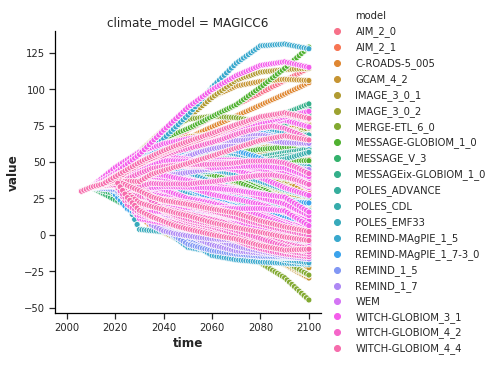

<IPython.core.display.Javascript object>

In [17]:
if SHOW_PLOTS:
    df = online_budget_runs_iam_df.filter(
        variable="Emissions|CO2*Fossil*", region="World"
    ).data
    rp = sns.relplot(data=df, x="time", y="value", hue="model", col="climate_model")

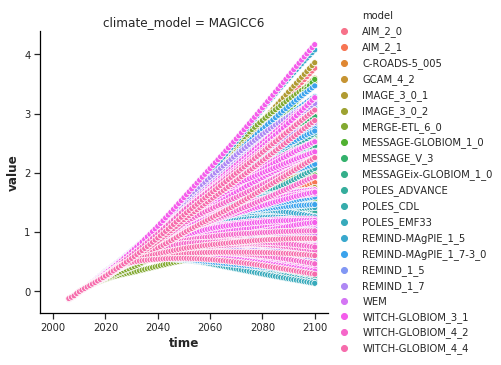

<IPython.core.display.Javascript object>

In [18]:
if SHOW_PLOTS:
    df = online_budget_runs_iam_df.filter(
        variable="Surface Temperature*rel*", region="World"
    ).data
    rp = sns.relplot(data=df, x="time", y="value", hue="model", col="climate_model")
    # ax = rp.axes[0][0]
    # ax.set_ylim([-1, 4.5]);

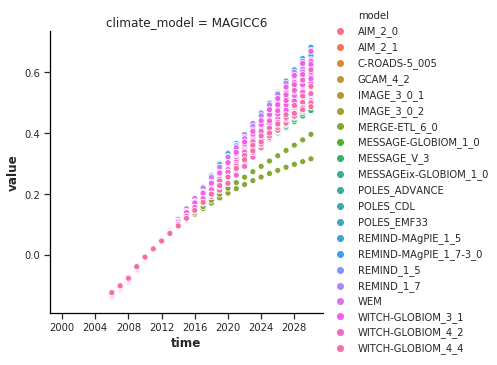

<IPython.core.display.Javascript object>

In [19]:
if SHOW_PLOTS:
    df = online_budget_runs_iam_df.filter(
        variable="Surface Temperature*rel*", region="World", year=range(2000, 2031)
    ).data
    rp = sns.relplot(data=df, x="time", y="value", hue="model", col="climate_model")
    # ax = rp.axes[0][0]
    # ax.set_ylim([-1, 4.5]);

SR1.5 assessed the remaining carbon budget for a given level of peak warming. Hence, for each scenario, we extract the peak warming and the cumulative emissions of CO$_2$ up until net zero i.e. the peak cumulative emissions of CO$_2$

In [20]:
online_budget_runs_df = online_budget_runs_iam_df.data
online_budget_runs_df.head()

model                scenario region                  variable    unit  \
725  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
728  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
731  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
734  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
737  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   

                    time  co2_fraction_gpp_2_detritus carbon_cycle_tuning  \
725  2006-01-01 00:00:00                     0.399817             default   
728  2007-01-01 00:00:00                     0.399817             default   
731  2008-01-01 00:00:00                     0.399817             default   
734  2009-01-01 00:00:00                     0.399817             default   
737  2010-01-01 00:00:00                     0.399817             default   

     pf_apply  co2_fraction_gpp_2_plant  ...  co2_feedbackfactor_gpp  endyear  \
725       1.0                  0.448261  ...                  0.0107     2110   
728       1.0                  0.448261  ...                  0.0107     2110   
731       1.0                  0.448261  ...                  0.0107     2110   
734       1.0                  0.448261  ...                  0.0107     2110   
737       1.0                  0.448261  ...                  0.0107     2110   

     co2_fraction_plant_2_detritus  rf_total_runmodus  co2_gpp_initial  \
725                       0.998902                all          66.2716   
728                       0.998902                all          66.2716   
731                       0.998902                all          66.2716   
734                       0.998902                all          66.2716   
737                       0.998902                all          66.2716   

     co2_feedbackfactor_respiration  out_permafrost  \
725                        0.068459             1.0   
728                        0.068459             1.0   
731                        0.068459             1.0   
734                        0.068459             1.0   
737                        0.068459             1.0   

     oceancc_scale_impulseresponse co2_soilpool_initial        value  
725                       0.949286             1681.525  1704.935357  
728                       0.949286             1681.525  1739.133257  
731                       0.949286             1681.525  1773.919291  
734                       0.949286             1681.525  1809.294924  
737                       0.949286             1681.525  1845.259791  

[5 rows x 45 columns]

<IPython.core.display.Javascript object>

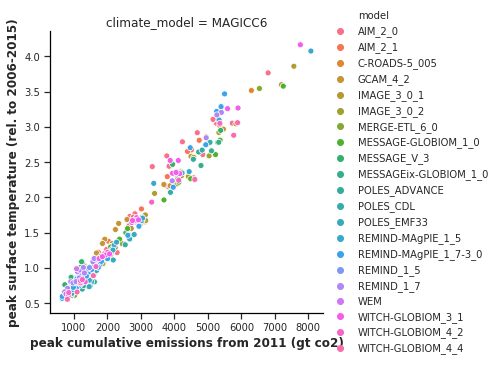

<IPython.core.display.Javascript object>

In [21]:
df = online_budget_runs_df[
    [
        "peak cumulative emissions from {} ({})".format(
            CUMULATIVE_EMISSIONS_REF_YEAR, str(cumulative_emissions_co2_units).lower()
        ),
        "peak surface temperature {}".format(REF_PERIOD_ID_STRING),
        "model",
        "scenario",
        "climate_model",
    ]
].drop_duplicates()
rp = sns.relplot(
    data=df,
    x="peak cumulative emissions from {} ({})".format(
        CUMULATIVE_EMISSIONS_REF_YEAR, str(cumulative_emissions_co2_units).lower()
    ),
    y="peak surface temperature {}".format(REF_PERIOD_ID_STRING),
    hue="model",
    col="climate_model",
)
rp.savefig(ONLINE_BUDGET_CUMULATIVE_EMISSIONS_TEMP_FIGURE)
# ax = rp.axes[0][0]
# ax.set_xlim([0, 3000])
# ax.set_ylim([0, 4.5]);

### Offline budget

#### TCRE

In [22]:
offline_tcre_df = get_1_percent_tcre_df(res_iam_df)
offline_tcre_df.head()

time  Atmospheric Concentrations|CO2  Inverse Emissions|CO2  \
0 1850-01-01                           278.0                    0.0   
1 1851-01-01                           278.0                    0.0   
2 1852-01-01                           278.0                    0.0   
3 1853-01-01                           278.0                    0.0   
4 1854-01-01                           278.0                    0.0   

   Cumulative Inverse Emissions|CO2  Surface Temperature  
0                               0.0                  0.0  
1                               0.0                  0.0  
2                               0.0                  0.0  
3                               0.0                  0.0  
4                               0.0                  0.0

<IPython.core.display.Javascript object>

#### ZEC

In [23]:
zec_iam_df = res_iam_df.filter(
    variable=[
        "Cumulative Emissions|CO2*",
        "Emissions|CO2*",
        "Radiative Forcing",
        "Surface Temperature",
    ],
    region="World",
    scenario="ZEC-diagnosis*",
    year=range(1750, 2250),
)
zec_df = zec_iam_df.data

<IPython.core.display.Javascript object>

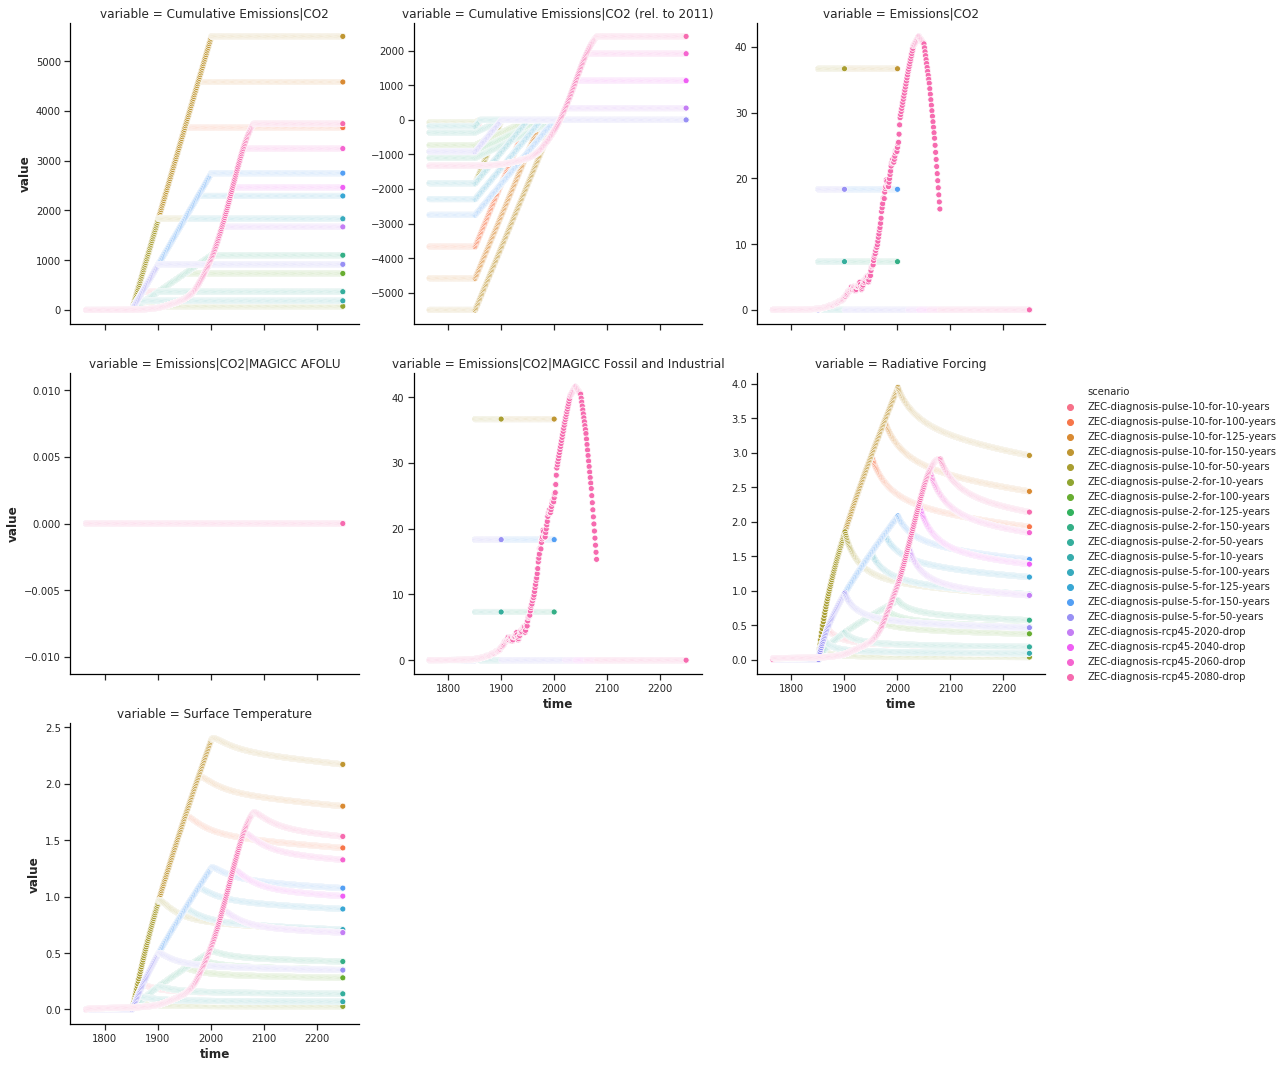

<IPython.core.display.Javascript object>

In [24]:
if SHOW_PLOTS:
    plt_kwargs = {
        "data": zec_df,
        "x": "time",
        "y": "value",
        "hue": "scenario",
        "col": "variable",
        "col_wrap": 3,
        "facet_kws": {"sharey": False},
    }
    sns.relplot(**plt_kwargs)

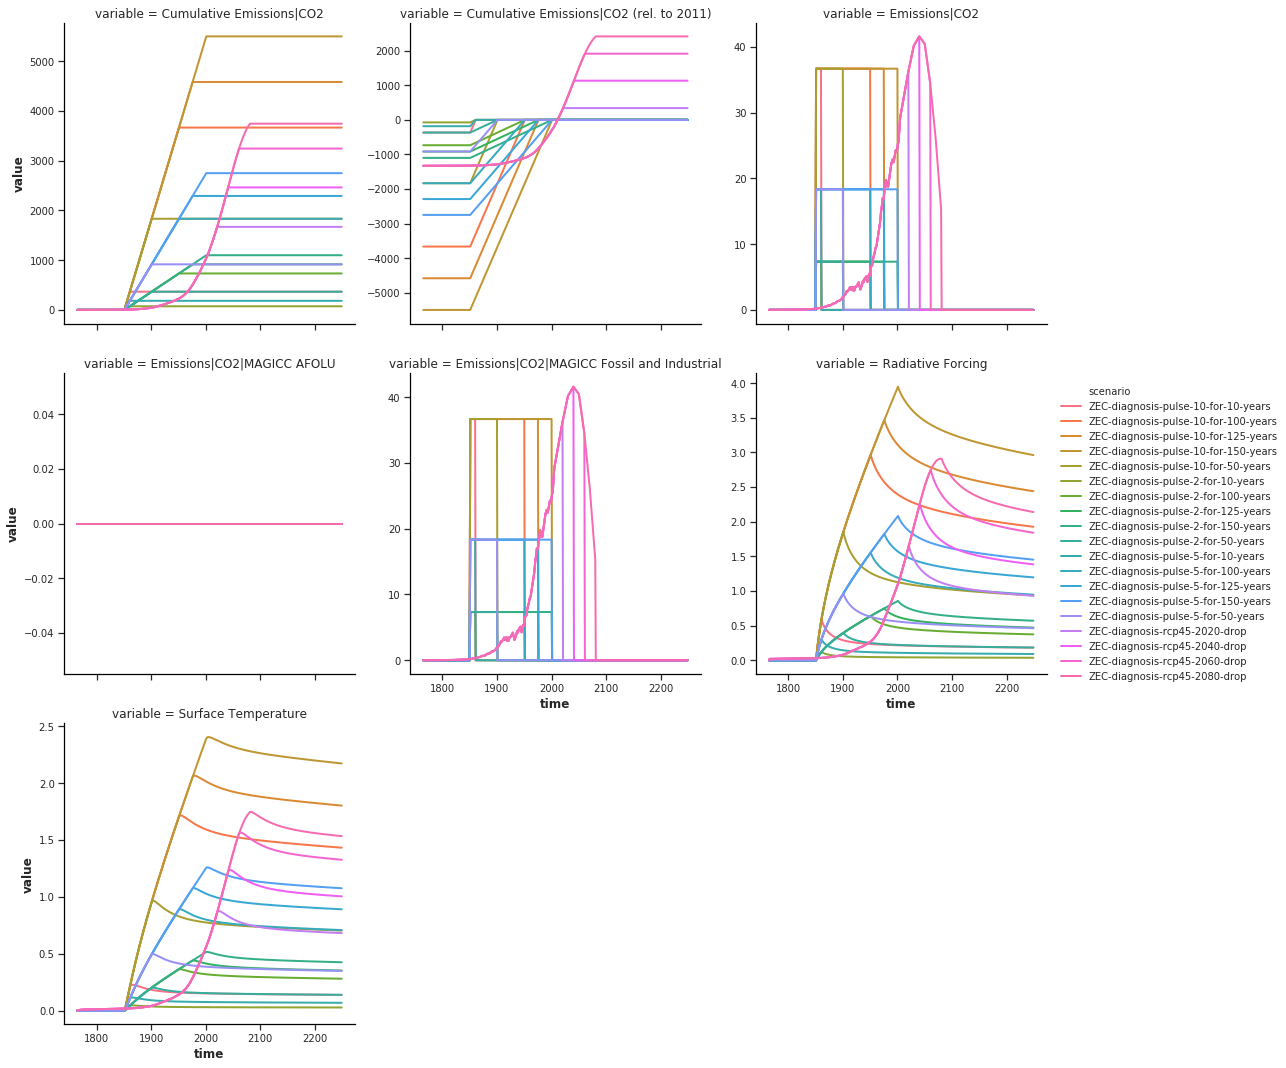

<IPython.core.display.Javascript object>

In [25]:
if SHOW_PLOTS:
    sns.relplot(kind="line", ci=None, **plt_kwargs)  # much slower if we calculate ci

As we are only interested in peak warming, the ZEC is simply calculated as the median of peak warming minus the warming in the year before zero emissions over all the experiments we did (where here zero emissions refers to zero CO2I emissions as that's what's used in the assessment although CO2B emissions are zero in all of these assessments anyway so the distinction doesn't matter). The reason we do the year before zero emissions is that we want to answer the question, "If we were to drop emissions abruptly to zero, what would the warming be?", and if we start measuring from a year in which emissions are already zero then we instead answer the question, "Once emissions are zero, what would the warming be?". (Although the numbers are so small that it really doesn't matter).

In [26]:
def get_zec_scatter_dfs(zec_iam_indf):
    tdf_dict = get_zero_variable_scenarios_year_before_zero_variable_peak_temp_thereafter_rows(
        zec_iam_indf, "Emissions|CO2"
    )
    zec_scatter_df_peak_temp = tdf_dict["peak_temp"]
    zec_scatter_df_zero_emms = tdf_dict["zero_emms"]

    zec_scatter_df = zec_scatter_df_peak_temp.copy()
    zec_scatter_df["ZEC"] = (
        zec_scatter_df_peak_temp["Surface Temperature"]
        - zec_scatter_df_zero_emms["Surface Temperature"]
    )
    zec_scatter_df = zec_scatter_df.reset_index()
    zec_scatter_df = zec_scatter_df.rename({"time": "peak_temp_time"}, axis="columns")

    return zec_scatter_df, zec_scatter_df_peak_temp, zec_scatter_df_zero_emms


zec_scatter_df, zec_scatter_df_peak_temp, zec_scatter_df_zero_emms = get_zec_scatter_dfs(
    zec_iam_df
)
zec_scatter_df.tail()

carbon_cycle_tuning                              scenario climate_model  \
14             default  ZEC-diagnosis-pulse-10-for-150-years       MAGICC6   
15             default         ZEC-diagnosis-rcp45-2020-drop       MAGICC6   
16             default         ZEC-diagnosis-rcp45-2040-drop       MAGICC6   
17             default         ZEC-diagnosis-rcp45-2060-drop       MAGICC6   
18             default         ZEC-diagnosis-rcp45-2080-drop       MAGICC6   

        model peak_temp_time  Cumulative Emissions|CO2  \
14  Idealised     2005-01-01               5500.000000   
15  Idealised     2024-01-01               1670.268268   
16  Idealised     2044-01-01               2463.418685   
17  Idealised     2064-01-01               3244.567552   
18  Idealised     2082-01-01               3745.029052   

    Cumulative Emissions|CO2 (rel. to 2011)  Emissions|CO2  \
14                                 0.000000            0.0   
15                               341.097350            0.0   
16                              1134.247767            0.0   
17                              1915.396633            0.0   
18                              2415.858133            0.0   

    Emissions|CO2|MAGICC AFOLU  Emissions|CO2|MAGICC Fossil and Industrial  \
14                         0.0                                         0.0   
15                         0.0                                         0.0   
16                         0.0                                         0.0   
17                         0.0                                         0.0   
18                         0.0                                         0.0   

    Radiative Forcing  Surface Temperature       ZEC  
14           3.866342             2.404714  0.025675  
15           1.569371             0.875856  0.028578  
16           2.171467             1.237534  0.031553  
17           2.663463             1.565745  0.023391  
18           2.884919             1.747895  0.006405

<IPython.core.display.Javascript object>

#### Non-CO$_2$ Contribution

In [27]:
def get_nonco2_iam_df(in_iam_df):
    scenario_runs_df = in_iam_df.filter(scenario=["1%*", "*ZEC*"], keep=False)

    nonco2_iam_df = scenario_runs_df.filter(
        variable=[
            "Cumulative Em*CO2",
            "Em*CO2",
            "Radiative Forcing",
            "Surface Temperature*",
        ],
        region="World",
        year=range(1, 2101),
    )
    nonco2_iam_df = nonco2_iam_df.filter(pf_apply=0, rf_total_runmodus="CO2").append(
        nonco2_iam_df.filter(pf_apply=0, rf_total_runmodus="all")
    )

    return nonco2_iam_df


nonco2_iam_df = get_nonco2_iam_df(res_iam_df)
nonco2_df = nonco2_iam_df.data
nonco2_df.head()

model                scenario region                  variable    unit  \
0  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
1  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
2  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
3  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   
4  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Cumulative Emissions|CO2  Gt CO2   

        time  co2_fraction_gpp_2_detritus carbon_cycle_tuning  pf_apply  \
0 1765-01-01                     0.399817             default       0.0   
1 1765-01-01                     0.399817             default       0.0   
2 1766-01-01                     0.399817             default       0.0   
3 1766-01-01                     0.399817             default       0.0   
4 1767-01-01                     0.399817             default       0.0   

   co2_fraction_gpp_2_plant  ...  co2_feedbackfactor_gpp  endyear  \
0                  0.448261  ...                  0.0107     2105   
1                  0.448261  ...                  0.0107     2105   
2                  0.448261  ...                  0.0107     2105   
3                  0.448261  ...                  0.0107     2105   
4                  0.448261  ...                  0.0107     2105   

   co2_fraction_plant_2_detritus  rf_total_runmodus  co2_gpp_initial  \
0                       0.998902                CO2          66.2716   
1                       0.998902                all          66.2716   
2                       0.998902                CO2          66.2716   
3                       0.998902                all          66.2716   
4                       0.998902                CO2          66.2716   

   co2_feedbackfactor_respiration  out_permafrost  \
0                        0.068459             1.0   
1                        0.068459             1.0   
2                        0.068459             1.0   
3                        0.068459             1.0   
4                        0.068459             1.0   

   oceancc_scale_impulseresponse co2_soilpool_initial     value  
0                       0.949286             1681.525  0.000000  
1                       0.949286             1681.525  0.000000  
2                       0.949286             1681.525  0.011000  
3                       0.949286             1681.525  0.011000  
4                       0.949286             1681.525  0.039595  

[5 rows x 45 columns]

<IPython.core.display.Javascript object>

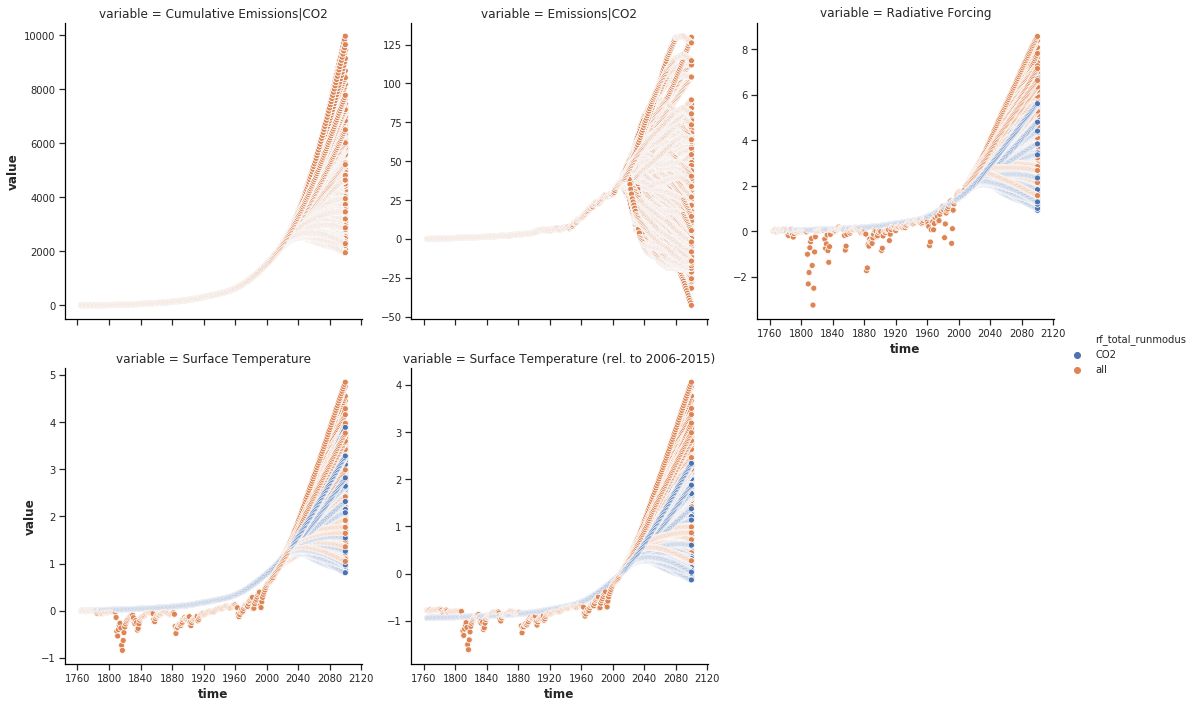

<IPython.core.display.Javascript object>

In [28]:
if SHOW_PLOTS:
    plt_kwargs = {
        "data": nonco2_df,
        "x": "time",
        "y": "value",
        "hue": "rf_total_runmodus",
        "col": "variable",
        "col_wrap": 3,
        "facet_kws": {"sharey": False},
    }
    sns.relplot(**plt_kwargs)

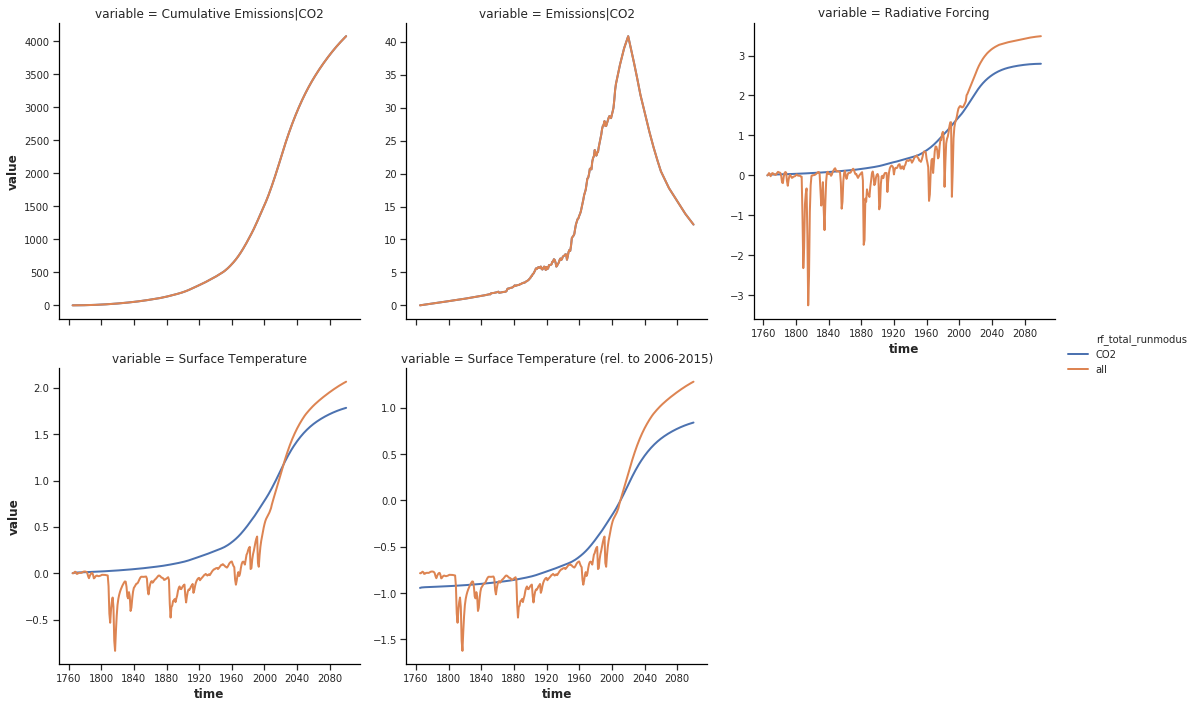

<IPython.core.display.Javascript object>

In [29]:
if SHOW_PLOTS:
    sns.relplot(kind="line", ci=None, **plt_kwargs)  # much slower if we calculate ci

To match SR1.5, here we diagnose the non-CO$_2$ temperature contribution by:

- determining the temperature difference between the non-CO$_2$ diagnosis and "all" runs at the time at which CO$_2$ emissions reach zero, in the process dropping scenarios where CO$_2$ emissions don't become net zero during the 21st century (here we choose to use the time at which total CO$_2$ emissions go to zero as we suspect that is what was done in SR1.5, however, we could be wrong and this choice clearly is inconsistent with assessing ZEC and TCRE from CO$_2$ Fossil and Industrial but how much that inconsistency matters is unclear given that it is unclear how emissions from land differ in net climate impact compared to fossil emissions)
    - we compare from a baseline period of 2006-2016. Whilst this means that the historical warming is impacting on our remaining carbon budget, it is the cleanest way to answer the question, "What perturbation does CO$_2$ alone cause from 2006-2015, compared to CO$_2$ and non-CO$_2$ drivers?" We explore alternate ways of assessing the non-CO$_2$ contribution in the `diagnosis-runs` notebook.
- plotting this temperature difference against peak temperature from the "all" runs
- performing a linear regression

In [30]:
def get_nonco2_scatter_df(in_nonco2_iam_df):
    idx = [
        "time",
        "model",
        "scenario",
        "climate_model",
        "rf_total_runmodus",
        "peak surface temperature {}".format(REF_PERIOD_ID_STRING),
    ]
    nonco2_scatter_df = (
        in_nonco2_iam_df.filter(year=range(2006, 2101))
        .pivot_table(index=idx, columns=["variable"], aggfunc="sum")
        .reset_index()
    )
    nonco2_scatter_df.columns.name = None

    nonco2_scatter_df = nonco2_scatter_df.groupby(idx).filter(
        lambda x: x["Emissions|CO2"] <= 0
    )
    keep = (
        nonco2_scatter_df.groupby(list(set(idx) - {"time"}))["time"].transform(min)
        == nonco2_scatter_df["time"]
    )
    nonco2_scatter_df = nonco2_scatter_df[keep].set_index(
        list(
            set(idx)
            - {
                "rf_total_runmodus",
                "peak surface temperature {}".format(REF_PERIOD_ID_STRING),
            }
        )
    )
    df_diff = (
        nonco2_scatter_df[nonco2_scatter_df["rf_total_runmodus"] == "all"][
            "Surface Temperature {}".format(REF_PERIOD_ID_STRING)
        ]
        - nonco2_scatter_df[nonco2_scatter_df["rf_total_runmodus"] == "CO2"][
            "Surface Temperature {}".format(REF_PERIOD_ID_STRING)
        ]
    )
    df_diff.name = "Surface Temperature non-CO2"

    nonco2_scatter_df = pd.concat(
        [
            nonco2_scatter_df[nonco2_scatter_df["rf_total_runmodus"] == "all"].drop(
                "rf_total_runmodus", axis="columns"
            ),
            df_diff,
        ],
        axis="columns",
    ).reset_index()

    return nonco2_scatter_df


nonco2_scatter_df = get_nonco2_scatter_df(nonco2_iam_df)
nonco2_scatter_df.tail()

time             scenario climate_model              model  \
200 2098-01-01  EMF33_Med2C_cost100       MAGICC6        POLES_EMF33   
201 2099-01-01    EMF33_tax_hi_full       MAGICC6            AIM_2_1   
202 2099-01-01     EMF33_Med2C_full       MAGICC6        POLES_EMF33   
203 2100-01-01   EMF33_WB2C_nobeccs       MAGICC6        POLES_EMF33   
204 2100-01-01              SSP1-34       MAGICC6  WITCH-GLOBIOM_3_1   

     peak surface temperature (rel. to 2006-2015)  Cumulative Emissions|CO2  \
200                                      0.826647               3352.361247   
201                                      1.184599               3610.014211   
202                                      0.817888               3364.528017   
203                                      0.634985               2825.276374   
204                                      1.187984               3886.860707   

     Emissions|CO2  Radiative Forcing  Surface Temperature  \
200      -0.152460           2.519053             1.546663   
201      -0.046787           3.322855             1.965496   
202      -0.011110           2.523503             1.544274   
203      -0.066367           1.944185             1.220028   
204      -0.242367           3.207113             1.968821   

     Surface Temperature (rel. to 2006-2015)  Surface Temperature non-CO2  
200                                 0.756921                     0.204295  
201                                 1.182897                     0.513488  
202                                 0.754534                     0.197395  
203                                 0.430287                     0.123483  
204                                 1.181888                     0.379404

<IPython.core.display.Javascript object>

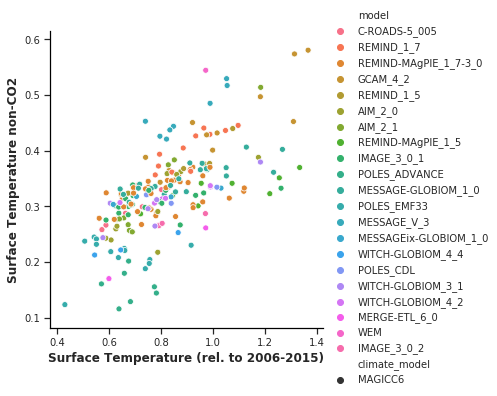

<IPython.core.display.Javascript object>

In [31]:
if SHOW_PLOTS:
    plt_kwargs = {
        "data": nonco2_scatter_df,
        "x": "Surface Temperature {}".format(REF_PERIOD_ID_STRING),
        "y": "Surface Temperature non-CO2",
        "hue": "model",
        "style": "climate_model",
    }
    sns.relplot(**plt_kwargs)

#### Permafrost feedback

In [32]:
scenario_runs_df = res_iam_df.filter(scenario=["*1%*", "*ZEC*"], keep=False).filter(
    variable=["Emissions|CO2|*", "*Permafrost", "Surface Temperature*rel*"],
    region="World",
    year=range(1, 2106),
)
permafrost_iam_df = scenario_runs_df.filter(rf_total_runmodus="all", pf_apply=0).append(
    scenario_runs_df.filter(rf_total_runmodus="all", pf_apply=1)
)
df = permafrost_iam_df.pivot_table(
    index=["time", "model", "scenario", "climate_model", "pf_apply"],
    columns=["variable"],
    aggfunc="sum",
)
df = df.reset_index().melt(
    id_vars=df.index.names, value_name="value", var_name="variable"
)

<IPython.core.display.Javascript object>

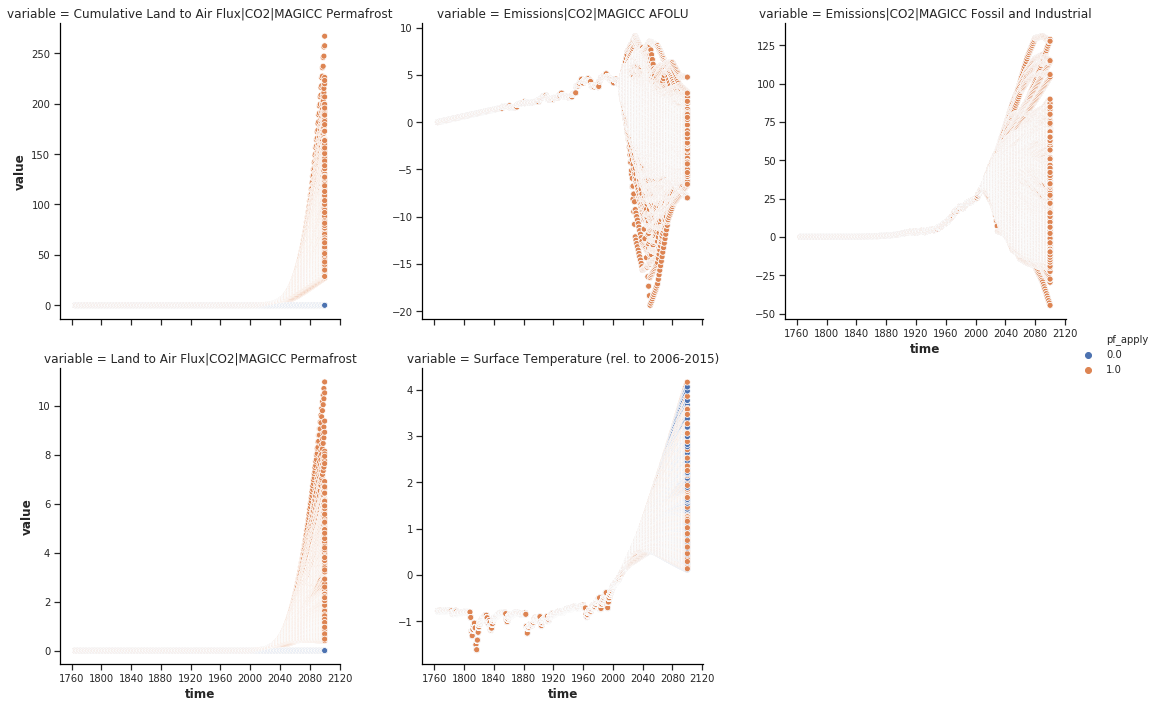

<IPython.core.display.Javascript object>

In [33]:
if SHOW_PLOTS:
    plt_kwargs = {
        "data": df,
        "x": "time",
        "y": "value",
        "hue": "pf_apply",
        "col": "variable",
        "col_wrap": 3,
        "facet_kws": {"sharey": False},
    }
    sns.relplot(**plt_kwargs)

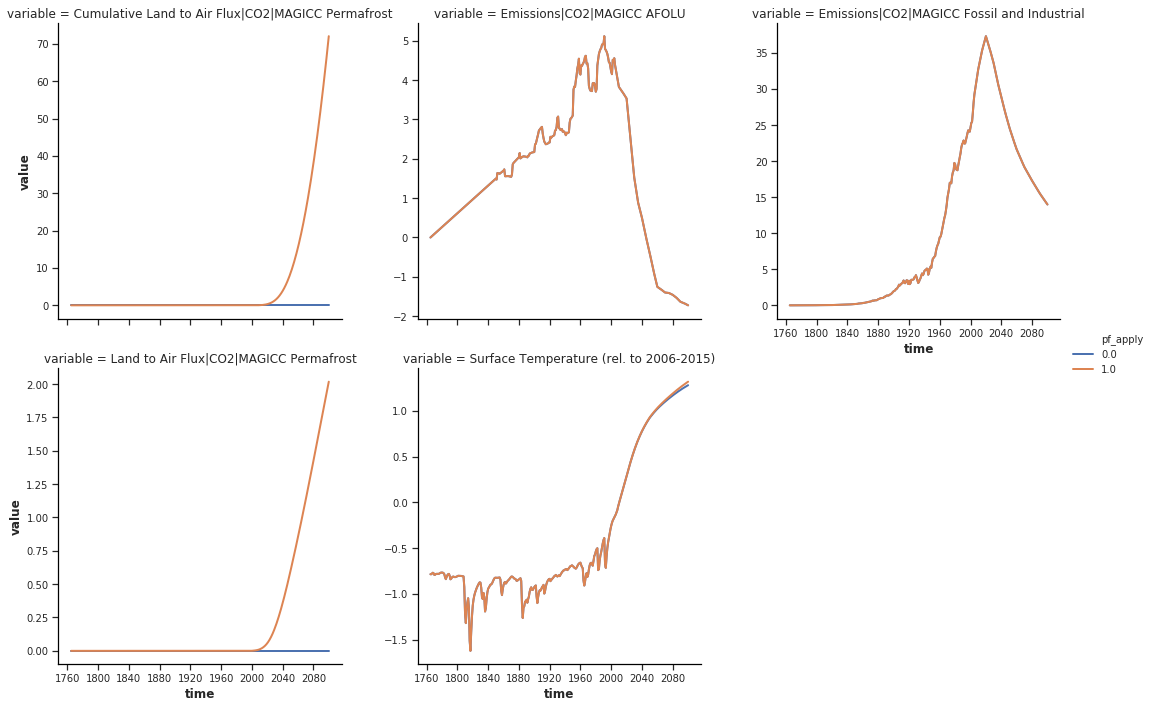

<IPython.core.display.Javascript object>

In [34]:
if SHOW_PLOTS:
    sns.relplot(kind="line", ci=None, **plt_kwargs)  # much slower if we calculate ci

In [35]:
def get_permafrost_plt_df(permafrost_scm_iamdf):
    permafrost_plt_df = (
        permafrost_scm_iamdf.filter(
            variable=[
                "Emissions|CO2|*",
                "Surface Temperature *rel*",
                "Land to Air Flux|CO2|MAGICC Permafrost",
                "Cumulative Land to Air Flux|CO2|MAGICC Permafrost",
            ],
            year=range(2000, 2106),
        )
        .to_iamdataframe()
        .pivot_table(
            index=["time", "model", "scenario", "climate_model"],
            columns=["variable"],
            aggfunc="sum",
        )
    )

    permafrost_plt_df["Emissions|CO2|Anthropogenic"] = (
        permafrost_plt_df["Emissions|CO2|MAGICC Fossil and Industrial"]
        + permafrost_plt_df["Emissions|CO2|MAGICC AFOLU"]
    )
    permafrost_plt_df = permafrost_plt_df[
        [
            "Emissions|CO2|Anthropogenic",
            "Surface Temperature {}".format(REF_PERIOD_ID_STRING),
            "Land to Air Flux|CO2|MAGICC Permafrost",
            "Cumulative Land to Air Flux|CO2|MAGICC Permafrost",
        ]
    ].reset_index()

    return permafrost_plt_df


permafrost_plt_df = get_permafrost_plt_df(permafrost_scm_df)
permafrost_plt_df.head()

variable       time    model                scenario climate_model  \
0        2000-01-01  AIM_2_0  ADVANCE_2020_1.5C-2100       MAGICC6   
1        2000-01-01  AIM_2_0      ADVANCE_2020_Med2C       MAGICC6   
2        2000-01-01  AIM_2_0       ADVANCE_2020_WB2C       MAGICC6   
3        2000-01-01  AIM_2_0      ADVANCE_2030_Med2C       MAGICC6   
4        2000-01-01  AIM_2_0  ADVANCE_2030_Price1.5C       MAGICC6   

variable  Emissions|CO2|Anthropogenic  \
0                           28.907267   
1                           28.907267   
2                           28.907267   
3                           28.907267   
4                           28.907267   

variable  Surface Temperature (rel. to 2006-2015)  \
0                                       -0.258529   
1                                       -0.258508   
2                                       -0.258529   
3                                       -0.258567   
4                                       -0.258430   

variable  Land to Air Flux|CO2|MAGICC Permafrost  \
0                                       0.000447   
1                                       0.000447   
2                                       0.000447   
3                                       0.000447   
4                                       0.000447   

variable  Cumulative Land to Air Flux|CO2|MAGICC Permafrost  
0                                                   0.00022  
1                                                   0.00022  
2                                                   0.00022  
3                                                   0.00022  
4                                                   0.00022

<IPython.core.display.Javascript object>

## Run over all carbon cycle tunings and save output

In [36]:
for cc_tuning in ["default"] + list(CARBON_CYCLE_FILES.keys()):
    print(cc_tuning)
    try:
        permafrost_scm_df = load_permafrost_df(cc_tuning)
        res_cc = load_res_cc(cc_tuning)
    except OSError as e:
        print("Can't find permafrost file for {}".format(cc_tuning))
        print(str(e))
        continue

    res_cc = strip_scenario_data_post_2100(res_cc)
    res_cc = add_temperature_relative_to_baseline(res_cc)

    permafrost_scm_df = add_temperature_relative_to_baseline(permafrost_scm_df)

    res_cc = convert_to_gtco2(res_cc)
    permafrost_scm_df = convert_to_gtco2(permafrost_scm_df)

    res_cc = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
        res_cc,
        cumulative_emissions_peak_ref_year=CUMULATIVE_EMISSIONS_REF_YEAR,
        peak_temperature_id_string=REF_PERIOD_ID_STRING,
    )

    permafrost_scm_df = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
        permafrost_scm_df,
        cumulative_emissions_peak_ref_year=CUMULATIVE_EMISSIONS_REF_YEAR,
        peak_temperature_id_string=REF_PERIOD_ID_STRING,
        include_inverse_co2_emissions=False,
        include_permafrost_emissions=True,
        include_peaks=False,
    )

    res_cc = add_cumulative_emms_rel_to_ref_year(res_cc)

    res_iam_df = res_cc.to_iamdataframe()
    online_budget_runs_iam_df = res_iam_df.filter(
        pf_apply=1.0, rf_total_runmodus="all", year=range(2006, 30000)
    )
    online_budget_runs_df = online_budget_runs_iam_df.data

    offline_tcre_df = get_1_percent_tcre_df(res_iam_df, carbon_cycle_tuning=cc_tuning)

    zec_iam_df = res_iam_df.filter(
        variable=[
            "Cumulative Emissions|CO2*",
            "Emissions|CO2*",
            "Radiative Forcing",
            "Surface Temperature",
        ],
        region="World",
        scenario="ZEC-diagnosis*",
        year=range(1750, 2250),
    )
    zec_df = zec_iam_df.data
    zec_scatter_df, zec_scatter_df_peak_temp, zec_scatter_df_zero_emms = get_zec_scatter_dfs(
        zec_iam_df
    )

    nonco2_iam_df = get_nonco2_iam_df(res_iam_df)
    nonco2_df = nonco2_iam_df.data
    nonco2_scatter_df = get_nonco2_scatter_df(nonco2_iam_df)

    permafrost_plt_df = get_permafrost_plt_df(permafrost_scm_df)

    save_df(zec_scatter_df, add_cc_name(ZEC_SCATTER_DF_H5, cc_tuning))
    save_df(
        zec_scatter_df_peak_temp, add_cc_name(ZEC_SCATTER_DF_PEAK_TEMP_H5, cc_tuning)
    )
    save_df(
        zec_scatter_df_zero_emms, add_cc_name(ZEC_SCATTER_DF_ZERO_EMMS_H5, cc_tuning)
    )

    save_scmdataframe(zec_iam_df, add_cc_name(ZEC_IAM_DF_H5, cc_tuning))

    save_df(permafrost_plt_df, add_cc_name(PERMAFROST_PLT_DF_H5, cc_tuning))
    save_scmdataframe(nonco2_iam_df, add_cc_name(NONCO2_IAM_DF_H5, cc_tuning))
    save_df(nonco2_scatter_df, add_cc_name(NONCO2_SCATTER_DF_H5, cc_tuning))
    save_df(offline_tcre_df, add_cc_name(OFFLINE_TCRE_DF_H5, cc_tuning))

    save_df(online_budget_runs_df, add_cc_name(ONLINE_BUDGET_RUNS_DF_H5, cc_tuning))

default


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


UVIC


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


BERN


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


LLNL


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


CCSM1


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


CLIMBER


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


MPI


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


FRCGC


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


UMD2


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


HADLEY


indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


<IPython.core.display.Javascript object>